<a href="https://colab.research.google.com/github/emiliomercuri/hidrologia/blob/main/notebooks/2023_06-23_Modelagem_Hidrol%C3%B3gica_2_GR2M_Cambara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibração e Validação do modelo GR2M

### Bacia do Cambará

In [1]:
!gdown 1fYehlZHlnguwPvIo0M_fVK2QuiKGUdV7
!gdown 1yCDfODDRsIoY0_DzB2VUq-LjiJUGWbTC

Downloading...
From: https://drive.google.com/uc?id=1fYehlZHlnguwPvIo0M_fVK2QuiKGUdV7
To: /content/gr2m_model.py
100% 11.8k/11.8k [00:00<00:00, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yCDfODDRsIoY0_DzB2VUq-LjiJUGWbTC
To: /content/dados_cambara_mensais_2004-2008.csv
100% 4.49k/4.49k [00:00<00:00, 17.5MB/s]


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import gr2m_model

In [4]:
df  = pd.read_csv('dados_cambara_mensais_2004-2008.csv', index_col= 0, sep =',')
df.index=pd.to_datetime(df.index)
data = df.copy()
#data

----------PERIODO AQUECIMENTO, CALIBRACAO E VALIDACAO-------------
Periodo de aquecimento: 2004-01-31 00:00:00-2005-01-31 00:00:00
Periodo de calibracao:  2005-02-28 00:00:00-2007-09-30 00:00:00
Periodo de aqu+calibr:  2004-01-31 00:00:00-2007-09-30 00:00:00
Periodo de validacao:   2007-10-31 00:00:00-2008-12-31 00:00:00


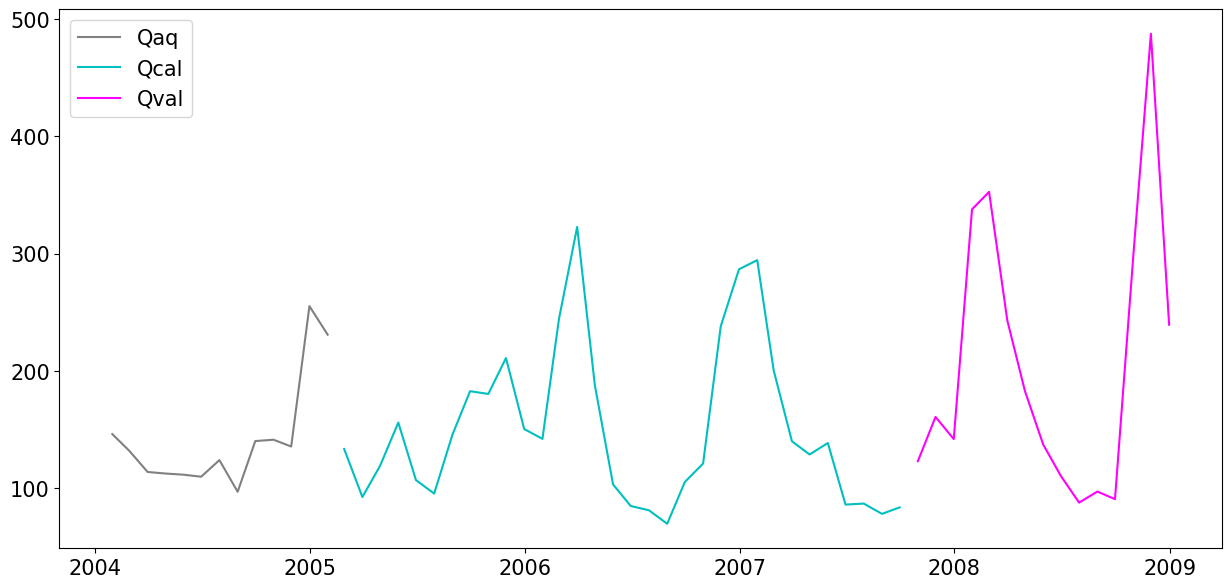

In [5]:
# =========================================================================
print('----------PERIODO AQUECIMENTO, CALIBRACAO E VALIDACAO-------------')
# =========================================================================
# periodo de aquecimento
aq_anos = 1  # anos
end_aq = pd.to_datetime(f"{df.index[0].year + aq_anos}/ {df.index[0].month}/ {df.index[0].day}", yearfirst=True)
h_aq = pd.date_range(end_aq, df.index[0]).shape[0] # dias

# data final da calibracao (2/3)
df2 = df.dropna(subset=['q(mm)'])
df2 = df2[df2.index > end_aq]
#end_cal =  df2.index[round((df2.shape[0]*1)/2)]
end_cal =  df2.index[round((df2.shape[0]*2)/3)]
start_cal = end_aq + pd.DateOffset(months=1)

# periodo de validação inicia um dia depois (1/3)
start_val = end_cal + pd.DateOffset(months=1)
#start_val = '2015-01-01'

# criar periodos
# aquecimento
aq = df[:end_aq]
# calibracao
cal = df[start_cal:end_cal]
# aquecimento mais calibracao
aqcal = df[:end_cal].copy()
# validacao
val = df[start_val:].copy()

# AQUCIMENTO/CALIBRACAO/VALIDACAO -----------------------------------------
print('Periodo de aquecimento: {}-{}'.format(aq.index[0],aq.index[-1]))
print('Periodo de calibracao:  {}-{}'.format(cal.index[0],cal.index[-1]))
print('Periodo de aqu+calibr:  {}-{}'.format(aqcal.index[0],aqcal.index[-1]))
print('Periodo de validacao:   {}-{}'.format(val.index[0],val.index[-1]))

'''Plotar grafico'''
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 15})
plt.plot(df.loc[:end_aq,'q(mm)'], label='Qaq',color='gray')
plt.plot(df.loc[start_cal:end_cal,'q(mm)'], label='Qcal',color='c')
plt.plot(df.loc[start_val:,'q(mm)'], label='Qval',color='magenta')
plt.legend()
#plt.title("Bacia {} ({})".format(nome,bacia))
plt.show()

In [6]:
fobj = 'NSE'
model = gr2m_model.GR2M()

In [10]:
# criar o periodo de calibracao e o periodo de validacao
cal = df[start_cal:end_cal].copy()
val = df[start_val:].copy()

### Calibrando o modelo GR2M

In [11]:
result = model.fit(cal['q(mm)'], cal['prec(mm/dia)'], cal['et(mm/dia)'])

In [12]:
# obtem os parametros
params = model.get_params(result)
print(result)
print('parametros: ',params)

 message: Optimization terminated successfully.
 success: True
     fun: 0.5928644438163336
       x: [ 5.576e+02  1.734e+00]
     nit: 12
    nfev: 399
     jac: [ 5.329e-07 -2.331e-07]
parametros:  {'x1': 557.6225813305629, 'x2': 1.7336521110655434}


### Simulação do GR2M

In [14]:
# Descarga simulada
df['Qsim (mm)'] = model.simulate(prec= df['prec(mm/dia)'],etp = df['et(mm/dia)'], params=params)

In [16]:
fobj_cal = round(gr2m_model.NSE(cal['Qsim (mm)'],cal['q(mm)']),4)
fobj_val = round(gr2m_model.NSE(val['Qsim (mm)'],val['q(mm)']),4)

print("{} calibracao: {:.4f}".format(fobj,fobj_cal))
print("{} validacao:  {:.4f}".format(fobj,fobj_val))

NSE calibracao: 0.6138
NSE validacao:  0.6324


### Gráfico do resultado da simulação

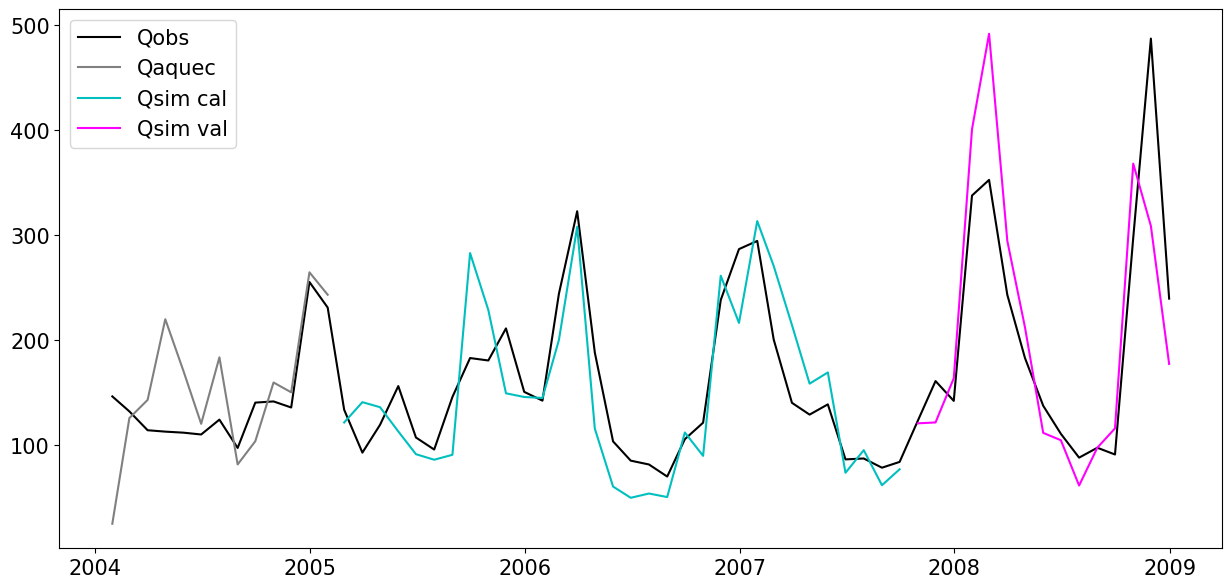

In [17]:
''' Plotar grafico completo '''
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 15})
plt.plot(df.loc[:,'q(mm)'], label='Qobs',color='black')
plt.plot(df.loc[:end_aq,'Qsim (mm)'], label='Qaquec',color='gray' )
plt.plot(df.loc[start_cal:end_cal ,'Qsim (mm)'], label='Qsim cal',color='c')
plt.plot(df.loc[start_val:,'Qsim (mm)'], label='Qsim val',color='magenta')
#plt.title("Bacia {} ({}) \n {} cal =  {:.4f}, {} val = {:.4f}".format(nome,bacia,fobj,fobj_cal,fobj,fobj_val))
plt.legend()
#plt.savefig(dir_figs / "{}.png".format(bacia))
plt.show()